__Note__: all text blocks are removed and are available in full chapter from publisher.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pylab as plt

In [2]:
from oedes import *
init_notebook()

In [3]:
thickness = 50e-9

In [4]:
import numpy as np

In [5]:
models.__file__

'/swedata-jamnik/home/marek/projects/oedes-private/oedes/models/__init__.py'

In [6]:
poisson = models.PoissonEquation()
thermal = models.ConstTemperature()
electron = models.BandTransport(name='electron', z=-1, 
                                thermal=thermal, poisson=poisson)
hole = models.BandTransport(name='hole', z=1, 
                            thermal=thermal, poisson=poisson)
poisson_bc = [models.AppliedVoltage('anode',owner=poisson),
              models.AppliedVoltage('cathode',owner=poisson)]
electron_bc = [models.LocalThermalEquilibriumContact('cathode',owner=electron)]
hole_bc = [models.LocalThermalEquilibriumContact('anode',owner=hole)]
intrinsic = models.Electroneutrality([electron, hole],name='intrinsic')
recombination = models.LangevinRecombination(intrinsic)
generation = models.DirectGeneration([electron,hole],absorption_density,name=None,param_name='G')
current = models.RamoShockleyCurrentCalculation([poisson])
bhj_equations = [poisson, poisson_bc, thermal, electron, electron_bc,
                 hole, hole_bc, intrinsic, recombination,
                 current]

In [7]:
mesh = fvm.mesh1d(thickness,boundary_names=['anode','cathode'])
discrete_model = fvm.discretize(bhj_equations, mesh)
c=context(discrete_model)

In [8]:
params={
    'epsilon_r':3, # Relative permittivity
    'T':300, # Temperature [K]
    'hole.mu':5e-7, # Hole mobility [m^2 1/V 1/s]
    'electron.mu':5e-7, # Electron mobility [m^2 1/V 1/s]
    'hole.N0':1e27, # Total DOS of holes [1/m^3]
    'electron.N0':1e27, # Total DOS of electrons [1/m^3]
    'hole.energy':-5.33, # HOMO [eV]
    'electron.energy':-3.9, # LUMO [eV]
    'anode.workfunction':5.33, # eV
    'cathode.workfunction':3.9, # eV
    'anode.voltage':0, # V
    'cathode.voltage':0, # V
    'G':0, # Scaling of generation profile
}

#### Solving for thermal equilibrium

In [9]:
c.solve(params) 

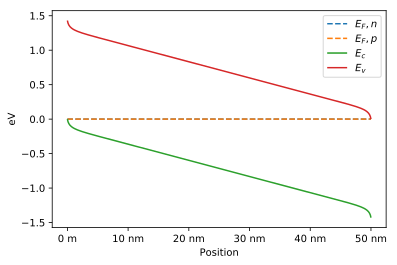

In [10]:
p=c.mpl()
p.plot(['hole.Ef'],linestyle='--',label='$E_F,n$')
p.plot(['electron.Ef'],linestyle='--',label='$E_F,p$')
p.plot(['hole.Eband'],'-',label='$E_c$')
p.plot(['electron.Eband'],'-',label='$E_v$')
p.ax.legend(loc=0)
p.apply_settings({})

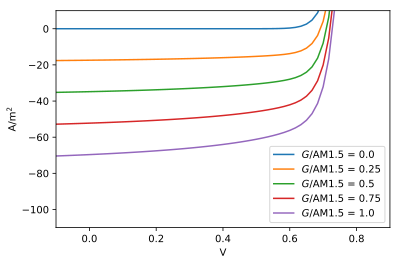

In [11]:
voltage_sweep = sweep('anode.voltage',np.linspace(-0.1,0.9,61))
light_sweep = sweep('G',np.linspace(0,1,5))
for intensity,c_oneintensity in c.sweep(params, light_sweep):
    for _ in c_oneintensity.sweep(c_oneintensity.params, voltage_sweep):
        # This loops over voltage volues
        pass
    plt.plot(*c_oneintensity.teval('anode.voltage', 'J'), label=r'$G/\mathrm{AM1.5}$ = %s'%intensity)
plt.legend(loc='best')
plt.autoscale(tight=True)
plt.ylim([-110,10]);
plt.xlabel('V')
plt.ylabel(r'$\mathrm{A/m^2}$');